In [ ]:
from typing import Dict, List, Optional, Tuple, TypeAlias, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import polars as pl
from pydantic import BaseModel, ConfigDict, Field

In [2]:
rng: np.random.Generator = np.random.default_rng(seed=12)

## Impact of New Arms on Exploration

### Problem Setup

We have a **dynamic Bernoulli multi-armed bandit** where arms can appear at different points in time.

* Let there be an initial set of $K_0$ arms with unknown but fixed success probabilities
  $\theta_0 = (\theta_{0,1}, \theta_{0,2}, \dots, \theta_{0,K_0}), \qquad \theta_{0,k} \in (0,1).$

* At specific times $t \in \mathcal{T}_{\text{arrivals}}$, we introduce one or more new arms.
  For a new arm $j$ arriving at time $t_0$, we assign it a true mean reward $\theta_j$.

Thus, at any time $t$, the set of available arms is:

$$
\mathcal{A}(t) = \{1,\dots,K_0\} \cup \bigcup_{t_0 \leq t} \mathcal{A}_{\text{new}}(t_0)
$$

where $\mathcal{A}_{\text{new}}(t_0)$ is the set of new arms introduced at $t_0$.

1. **Outer union (`U` with the initial set)**

   * The first `U` is just a simple set union between two sets:

     * The set of indices of the original $K_0$ arms:
       $\{1, 2, \dots, K_0\}$

     * The set of all new arms that have arrived up to time $t$:
       $\bigcup_{t_0 \leq t} \mathcal{A}_{\text{new}}(t_0)$

   This ensures that $\mathcal{A}(t)$ includes both initial and newly arrived arms.

2. **Inner union ($\bigcup_{t_0 \leq t}$)**

   * This is a **union over time indices**. It collects all sets of arms that have arrived at each arrival time $t_0$ **up to time $t$**:

     $$
     \bigcup_{t_0 \leq t} \mathcal{A}_{\text{new}}(t_0)
     = \mathcal{A}_{\text{new}}(t_1) \cup \mathcal{A}_{\text{new}}(t_2) \cup \dots \cup \mathcal{A}_{\text{new}}(t_m)
     $$

     where $t_1, t_2, \dots, t_m$ are all the arrival times such that $t_i \leq t$.

   Intuition: this aggregates the **history of arrivals** into one set.

To summarize:

* **Inner union** = Collect all newly added arms that have arrived up to $t$
* **Outer union** = Combine those with the initial set of arms

In [3]:
BetaPrior: TypeAlias = Tuple[float, float]
MeanReward: TypeAlias = float
ArmLabel: TypeAlias = str

In [4]:
class DynamicBanditConfig(BaseModel):
    """
    Configuration for the dynamic bandit algorithm.

    Attributes
    ----------
    initial_means : List[MeanReward]
        The initial mean rewards for each arm.
    initial_priors : List[BetaPrior]
        The initial (alpha, beta) priors for each arm in the same order as `initial_means`.
    batch_new_arms : Dict[int, Dict[ArmLabel, MeanReward]]
        A mapping of time step to new arms introduced at that time, with arm labels and their means.
    batch_new_priors : Dict[int, Dict[ArmLabel, BetaPrior]]
        Mapping of time step to new arms' (alpha, beta) priors introduced at that time.
        Any missing `arm_label` at a given `t` uses Beta(1, 1) as the prior.
    horizon : int
        The total number of time steps.
    """

    model_config = ConfigDict(arbitrary_types_allowed=True)

    initial_means: List[MeanReward] = Field(
        ..., description="Initial mean rewards for each arm."
    )
    initial_priors: List[BetaPrior] = Field(
        ..., description="Initial Beta priors (alpha, beta) for each arm."
    )
    batch_new_arms: Dict[int, Dict[ArmLabel, MeanReward]] = Field(
        ..., description="Time step -> new arms with mean rewards."
    )
    batch_new_priors: Dict[int, Dict[ArmLabel, BetaPrior]] = Field(
        ..., description="Time step -> new arms with Beta priors."
    )
    horizon: int = Field(
        ..., ge=1, description="Total number of time steps (must be >= 1)."
    )

In [5]:
class DynamicBernoulliBandit(object):
    """
    Dynamic Bernoulli bandit environment supporting batch arm arrivals.

    This class models a non-stationary multi-armed bandit where new arms can
    be introduced at specific time steps according to a user-supplied schedule.
    Each arm returns Bernoulli rewards with fixed but unknown mean.

    Attributes
    ----------
    rng : numpy.random.Generator
        Pseudo-random number generator used for reward draws.
    horizon : int
        Total number of time steps for the bandit horizon.
    _batch : Dict[int, Dict[ArmLabel, MeanReward]]
        Mapping from time t -> {arm_label: true_mean} defining when new arms are added.
    arm_means : List[MeanReward]
        List of true success probabilities for currently available arms.
    arm_labels : List[ArmLabel]
        Human-readable labels for each arm (initial arms labeled "init_0", "init_1", ...).
    """

    def __init__(self, config: DynamicBanditConfig, rng: np.random.Generator) -> None:
        """
        Initialize the dynamic Bernoulli bandit with the given configuration and random number generator.

        Parameters
        ----------
        config : DynamicBanditConfig
            Configuration specifying initial arm means, arm arrival schedule, their respective priors, and time horizon.
        rng : numpy.random.Generator
            Pseudo-random number generator for sampling rewards.

        Returns
        -------
        None
        """
        self.rng: np.random.Generator = rng
        self.horizon: int = int(config.horizon)
        self._batch: Dict[int, Dict[str, float]] = config.batch_new_arms
        self.arm_means: List[float] = list(config.initial_means)
        self.arm_labels: List[str] = [f"init_{i}" for i in range(len(self.arm_means))]

    def add_arms(self, t: int) -> List[int]:
        """
        Add any arms scheduled to appear at time t.

        Parameters
        ----------
        t : int
            Current time step.

        Returns
        -------
        List[int]
            Indices of the arms that were added at this step. If no new arms are scheduled for time t, returns an empty list.
        """
        new_indices: List[int] = []
        # Check if any arms are scheduled to be added at time t
        if t in self._batch:
            for label, mean in self._batch[t].items():
                self.arm_means.append(float(mean))
                self.arm_labels.append(str(label))
                new_indices.append(len(self.arm_means) - 1)
        return new_indices

    def pull(self, arm: int) -> int:
        """
        Pull an arm and sample a Bernoulli outcome. This is effectively simulating a Bernoulli(p) random variable
        where `p` is the true mean of the specified arm.

        Parameters
        ----------
        arm : int
            Index of the arm to pull (0-based).

        Returns
        -------
        int
            Reward outcome from Bernoulli(p), where p is the true mean of the arm.
        """
        p: float = self.arm_means[arm]
        return int(self.rng.random() < p)

    def optimal_mean(self) -> float:
        """
        Compute the true mean of the best currently available arm. This
        is used to compute instantaneous regret.

        Returns
        -------
        float
            Maximum of all arm success probabilities in `arm_means`.
        """
        return float(max(self.arm_means))

### Thompson Sampling Algorithm

We use **Thompson Sampling (TS)** with independent Beta priors for each arm.

* **Prior:** for arm $k$,

$$
\theta_k \sim \mathrm{Beta}(\alpha_0, \beta_0)
$$

* **Posterior update:** after pulling arm $k$ at time $t$ and observing reward outcome $r_t \in {0,1}$, we update:

$$
\alpha_k \leftarrow \alpha_k + r_t, \qquad 
\beta_k \leftarrow \beta_k + (1 - r_t).
$$

* **Selection rule:** at each $t$, sample

$$
\tilde{\theta}_k^{(t)} \sim \mathrm{Beta}(\alpha_k, \beta_k) \quad \forall \quad k \in \mathcal{A}(t)
$$

The action at time $t$ is selected as:

$$
a_t = \arg \max_{k \in \mathcal{A}(t)} \tilde{\theta}_k^{(t)}
$$

In [6]:
class ThompsonSampling(object):
    """
    Thompson Sampling policy for Bernoulli multi-armed bandits with dynamic arms.

    This implementation maintains independent Beta posteriors for each arm and
    uses random sampling from these posteriors to select arms. It supports
    dynamically adding new arms during execution and initializes them with
    a specified Beta prior.

    Attributes
    ----------
    alpha : npt.NDArray[np.floating]
        Alpha parameters for the Beta posterior of each arm.
    beta : npt.NDArray[np.floating]
        Beta parameters for the Beta posterior of each arm.
    """

    def __init__(
        self,
        init_priors: List[BetaPrior],
    ) -> None:
        """
        Parameters
        ----------
        init_priors : List[BetaPrior]

        Returns
        -------
        None
        """
        self.alpha: npt.NDArray[np.floating] = np.array(
            [float(a) for a, _ in init_priors], dtype=float
        )
        self.beta: npt.NDArray[np.floating] = np.array(
            [float(b) for _, b in init_priors], dtype=float
        )

    def add_new_arms(self, priors: List[BetaPrior]) -> None:
        """
        Append new arms with given priors.

        Parameters
        ----------
        priors : List[BetaPrior]
            Priors (alpha, beta) for new arms to be added.

        Returns
        -------
        None
        """
        new_alpha: npt.NDArray[np.floating] = np.array(
            [float(a) for a, _ in priors], dtype=float
        )
        new_beta: npt.NDArray[np.floating] = np.array(
            [float(b) for _, b in priors], dtype=float
        )
        self.alpha = np.concatenate([self.alpha, new_alpha])
        self.beta = np.concatenate([self.beta, new_beta])

    def select_arm(self, rng: np.random.Generator) -> int:
        """
        Select an arm using Thompson Sampling.

        Parameters
        ----------
        rng : numpy.random.Generator
            Random number generator used to draw samples from the Beta posteriors.

        Returns
        -------
        int
            Index of the arm selected (0-based).
        """
        samples: npt.NDArray[np.floating] = rng.beta(self.alpha, self.beta)
        return int(np.argmax(samples))

    def update(self, arm_index: int, outcome: int) -> None:
        """
        Update the posterior parameters after observing a reward.

        Parameters
        ----------
        arm : int
            Index of the arm that was pulled.
        outcome : int
            Observed outcome (1 for success, 0 for failure).

        Returns
        -------
        None
        """
        self.alpha[arm_index] += outcome
        self.beta[arm_index] += 1 - outcome

### Regret Computation

The **instantaneous regret** at time $t$ is the gap between the best available arm and the chosen arm:

$$
r_t^{\text{regret}} = \max_{k \in \mathcal{A}(t)} \theta_k \;-\; \theta_{a_t}
$$

The **cumulative regret** after $T$ steps is:

$$
R_T = \sum_{t=1}^T r_t^{\text{regret}}
$$

This is what we report as cumulative regret over time.

In [7]:
class SimulationResult(BaseModel):
    """
    Container for the results of a single Thompson Sampling simulation run.

    Attributes
    ----------
    outcomes : npt.NDArray[np.floating]
        Realized Bernoulli outcomes at each time step.
    instantaneous_regrets : npt.NDArray[np.floating]
        Instantaneous regret at each time step.
    cumulative_regrets : npt.NDArray[np.floating]
        Cumulative sum of instantaneous regret over time.
    chosen_arm_indices : npt.NDArray[np.int_]
        Indices of arms selected at each time step.
    num_arms_hist : npt.NDArray[np.int_]
        Number of available arms at each time step.
    arm_labels : List[str]
        Labels for all arms in index order at the end of the run.
    arrivals_map : Dict[int, List[Optional[int]]]
        Mapping from arrival time t to indices of newly added arms.
    """

    model_config = ConfigDict(arbitrary_types_allowed=True)

    outcomes: npt.NDArray[np.floating] = Field(...)
    instantaneous_regrets: npt.NDArray[np.floating] = Field(...)
    cumulative_regrets: npt.NDArray[np.floating] = Field(...)
    chosen_arm_indices: npt.NDArray[np.int_] = Field(...)
    num_arms_hist: npt.NDArray[np.int_] = Field(...)
    arm_labels: List[str] = Field(...)
    arrivals_map: Dict[int, List[int]] = Field(...)

In [8]:
def _priors_for_added_labels(
    t: int,
    labels_added: List[ArmLabel],
    config: DynamicBanditConfig,
) -> List[BetaPrior]:
    """
    Resolve per-arm priors for labels added at time t.

    Parameters
    ----------
    t : int
        Current time step.
    labels_added : List[ArmLabel]
        Labels of arms added at time t.
    config : DynamicBanditConfig
        Configuration for the dynamic bandit.

    Raises
    ------
    KeyError
        If a required label prior is missing at time t.

    Returns
    -------
    List[BetaPrior]
        Priors aligned with `labels_added`.
    """
    priors_map_t: Optional[Dict[ArmLabel, BetaPrior]] = config.batch_new_priors.get(
        t, None
    )
    if priors_map_t is None:
        raise KeyError(f"No new arm priors found for time step t = {t}")
    priors: List[BetaPrior] = []
    for label in labels_added:
        if label not in priors_map_t:
            raise KeyError(f"Missing Beta prior for new arm '{label}' at t = {t} ")
        a, b = priors_map_t[label]
        priors.append((float(a), float(b)))
    return priors

In [9]:
def simulate_once(
    config: DynamicBanditConfig, rng: np.random.Generator
) -> SimulationResult:
    """
    Run a single Thompson Sampling trajectory in a dynamic Bernoulli bandit with batch arrivals.

    Parameters
    ----------
    config : DynamicBanditConfig
        Environment and policy configuration. Must include initial arm means, arm arrival schedule, their respective priors, and time horizon.
    rng : numpy.random.Generator
        Pseudorandom number generator for sampling rewards.

    Returns
    -------
    SimulationResult

    Notes
    -----
    - The environment can add multiple new arms at a single time step.
    - New arms are initialized in the policy with specified Beta(alpha, beta) priors.
    - Instantaneous regret uses the true means to define the benchmark best arm at each time. This is standard for simulation analysis.
    """
    env: DynamicBernoulliBandit = DynamicBernoulliBandit(config, rng)
    ts_policy: ThompsonSampling = ThompsonSampling(init_priors=config.initial_priors)

    horizon: int = config.horizon
    outcomes: npt.NDArray[np.floating] = np.zeros(horizon, dtype=float)
    instantaneous_regrets: npt.NDArray[np.floating] = np.zeros(horizon, dtype=float)
    cumulative_regrets: npt.NDArray[np.floating] = np.zeros(horizon, dtype=float)
    chosen_arm_indices: npt.NDArray[np.int_] = np.zeros(horizon, dtype=int)
    num_arms_hist: npt.NDArray[np.int_] = np.zeros(horizon, dtype=int)

    # E.g. {5: [3, 4], 6: [], 7: [5]} means arms with indices 3 and 4 arrived at t = 5, no new arms at t = 6, and arm with index 5 arrived at t = 7
    arrivals_map: Dict[int, List[int]] = {}

    # For efficient cumulative regret calculation
    cumulative_regret_sum: float = 0.0

    for time_step in range(horizon):
        # Apply scheduled arrivals and record indices of added arms
        added_indices: List[int] = env.add_arms(time_step)
        if added_indices:
            arrivals_map[time_step] = added_indices
            # Resolve priors for these labels in the same order they were appended
            added_labels: List[ArmLabel] = [env.arm_labels[j] for j in added_indices]
            added_priors: List[BetaPrior] = _priors_for_added_labels(
                time_step, added_labels, config
            )
            # Extend TS posteriors so the new arms can be sampled and selected
            ts_policy.add_new_arms(added_priors)

        # Thompson step: sample from posteriors, pick the best sample, then pull
        arm_index: int = ts_policy.select_arm(rng)
        outcome_t: int = env.pull(arm_index)

        # Bayesian update of the chosen arm's Beta posterior with the new outcome (0 or 1)
        ts_policy.update(arm_index=arm_index, outcome=outcome_t)

        outcomes[time_step] = outcome_t
        best_mean_t: MeanReward = env.optimal_mean()
        chosen_mean_t: MeanReward = env.arm_means[arm_index]
        # Regret uses the gap between the best true mean at `t` and the chosen arm's true mean
        instantaneous_regrets[time_step] = best_mean_t - chosen_mean_t
        cumulative_regret_sum += instantaneous_regrets[time_step]
        cumulative_regrets[time_step] = cumulative_regret_sum
        chosen_arm_indices[time_step] = arm_index
        num_arms_hist[time_step] = len(env.arm_means)

    return SimulationResult(
        outcomes=outcomes,
        instantaneous_regrets=instantaneous_regrets,
        cumulative_regrets=cumulative_regrets,
        chosen_arm_indices=chosen_arm_indices,
        num_arms_hist=num_arms_hist,
        arm_labels=env.arm_labels,
        arrivals_map=arrivals_map,
    )

### Notations for Simulation Runs

* Let $n_{\text{runs}}$ be the number of independent Monte Carlo simulations.

* For run $i \in \{1, \ldots, n_{\text{runs}}\}$, let $a_t^{(i)}$ be the arm chosen at time $t$.

---

### Discovery Lag

For a new arm $j$ arriving at time $t_0$, define its **discovery lag** in run $i$ as:

$$
L_j^{(i)} = \min \{ \ell \ge 0 \mid a_{t_0 + \ell}^{(i)} = j \}
$$

i.e., the number of steps until the first time the algorithm selects arm $j$ after its arrival. Across $n_{\text{runs}}$ Monte Carlo simulations, the **average discovery lag** is:

$$
\bar{L}_j = \frac{1}{n_{\text{runs}}} \sum_{i=1}^{n_{\text{runs}}} L_j^{(i)}
$$

Interpretation:

* **Low $\bar{L}_j$** means the algorithm usually tried this arm almost immediately after it appeared.
* **High $\bar{L}_j$** means the algorithm usually took some time before trying this arm.

---

### Adoption Curves

To measure how quickly a new arm is **adopted**, we compute the cumulative selection rate within a fixed window $W$ after arrival:

$$
A_{j}^{(i)}(k) = \frac{1}{k} \sum_{\ell=0}^{k-1} \mathbb{1}\{a_{t_0+\ell}^{(i)} = j\}
\qquad k = 1,\dots, W
$$

The $A_{j}^{(i)}(k)$ is the fraction of times arm $j$ was chosen in the first $k$ steps after it appeared in run $i$. Then, average over all runs:

$$
\bar{A}_j(k) = \frac{1}{n_{\text{runs}}} \sum_{i=1}^{n_{\text{runs}}} A_j^{(i)}(k)
$$

Interpretation:

* $\bar{A}_j(k)$ is average selection rate, averaged over all runs.
* A **steep rise** indicates fast recognition and exploitation of the arm.

---

### Expected Pulls in First $k$ Steps

The expected number of pulls for arm $j$ in the first $k$ steps, as a point estimate, can be the expected selection rate multiplied by the total number of opportunities:

$$
\mathbb{E}[\text{Pulls in first k}] = k \times \bar{A}_j(k)
$$

For instance, if $\bar{A}_j(10) = 0.3$, then in the first 10 steps after arm $j$ appears, we expect it to be pulled about $10 \times 0.3 = 3$ times on average. This can be thought of as how much "exploration budget" was devoted to the new arm.

In [10]:
class AggregationResult(BaseModel):
    """
    Aggregated results across Monte Carlo runs.

    Attributes
    ----------
    mean_cum_regrets : npt.NDArray[np.floating]
        Average cumulative regret over time (shape: (T,)).
    new_arm_meta : List[Tuple[int, int, str]]
        Metadata tuples (arrival_time, arm_index, label) for every newly added arm.
    adoption_averages : Dict[Tuple[int, int], npt.NDArray[np.floating]]
        For each new arm keyed by (arrival_time, arm_index), an array of length `window_size`
        with the average cumulative selection rate within the first k steps after arrival.
        For arms arriving late, values beyond the remaining horizon are padded by the last
        valid cumulative rate.
    discovery_lags_averages : Dict[Tuple[int, int], float]
        For each new arm keyed by (arrival_time, arm_index), the average discovery lag in steps.
    window_size : int
        The window length used for adoption statistics.
    """

    model_config = ConfigDict(arbitrary_types_allowed=True)

    mean_cum_regrets: npt.NDArray[np.floating] = Field(...)
    new_arm_meta: List[Tuple[int, int, str]] = Field(...)
    adoption_averages: Dict[Tuple[int, int], npt.NDArray[np.floating]] = Field(...)
    discovery_lags_averages: Dict[Tuple[int, int], float] = Field(...)
    window_size: int = Field(...)

In [11]:
def simulate_many(
    n_runs: int,
    template_rng: np.random.Generator,
    config: DynamicBanditConfig,
    window_size: int = 60,
) -> AggregationResult:
    """
    Average multiple Thompson Sampling trajectories in a dynamic Bernoulli bandit with batch arrivals.

    Runs `simulate_once` repeatedly, aggregates time series across runs, and computes per-new-arm
    adoption statistics and discovery lags. Adoption windows are capped by the remaining horizon to
    avoid overcounting late arrivals. The adoption curves are then padded to `window_size` by
    repeating the last valid cumulative rate to preserve a uniform shape across arms.

    Parameters
    ----------
    n_runs : int
        Number of independent Monte Carlo runs to average over.
    template_rng : numpy.random.Generator
        RNG used for the template run to fix (arrival_time -> arm indices) mapping.
    config : DynamicBanditConfig
        Environment and policy configuration.
    window_size : int, default=60
        Post-arrival window length used to compute cumulative selection rates.

    Returns
    -------
    AggregationResult
        Aggregated metrics and metadata across runs.
    """
    T: int = int(config.horizon)

    # Matrices: rows = runs, cols = time
    cumulative_regrets_matrix: npt.NDArray[np.floating] = np.zeros(
        (n_runs, T), dtype=float
    )
    chosen_arm_indices_matrix: npt.NDArray[np.int_] = np.zeros((n_runs, T), dtype=int)

    # Template run to fix mapping (arrival_time -> arm indices) used in aggregation
    template_result: SimulationResult = simulate_once(config=config, rng=template_rng)
    arrivals_map: Dict[int, List[int]] = template_result.arrivals_map
    arm_labels: List[ArmLabel] = template_result.arm_labels

    # Metadata for new arms: (arrival_time, arm_index, arm_label)
    new_arm_meta: List[Tuple[int, int, ArmLabel]] = [
        (arrival_time, arm_index, arm_labels[arm_index])
        for arrival_time, arm_indices in arrivals_map.items()
        for arm_index in arm_indices
    ]

    # Per-new-arm collectors across runs
    adoption_series: Dict[Tuple[int, int], List[npt.NDArray[np.floating]]] = {
        (arrival_time, arm_index): [] for (arrival_time, arm_index, _) in new_arm_meta
    }
    discovery_lags: Dict[Tuple[int, int], List[int]] = {
        (arrival_time, arm_index): [] for (arrival_time, arm_index, _) in new_arm_meta
    }

    # Monte Carlo loop
    for run_id in range(n_runs):
        rng_i = np.random.default_rng(seed=run_id)
        res_i: SimulationResult = simulate_once(config=config, rng=rng_i)

        cumulative_regrets_matrix[run_id] = res_i.cumulative_regrets
        chosen_arm_indices_matrix[run_id] = res_i.chosen_arm_indices

        # Compute lag and adoption for each template new arm
        for arrival_time, arm_index, _ in new_arm_meta:
            # These are the arm choices from `arrival_time` until the end of the horizon
            post_choices: npt.NDArray[np.int_] = chosen_arm_indices_matrix[
                run_id, arrival_time:
            ]

            # Discovery lag: first offset where arm_index is chosen; max lag if never chosen
            hits: npt.NDArray[np.int_] = np.where(post_choices == arm_index)[0]
            lag_steps: int = int(hits[0]) if hits.size > 0 else (T - arrival_time)
            discovery_lags[(arrival_time, arm_index)].append(lag_steps)

            # Adoption curve: cap by remaining horizon, then pad to `window_size` if needed
            remaining: int = T - arrival_time
            # Address scenario: if an arm arrives at a time step with fewer than `window_size` steps left
            window_size_eff: int = int(min(window_size, remaining))
            # # This means we have arrived at the final step, i.e., no steps left to observe adoption (assume zero adoption)
            if window_size_eff == 0:
                padded: npt.NDArray[np.floating] = np.zeros(window_size, dtype=float)
                adoption_series[(arrival_time, arm_index)].append(padded)
                # No steps left to observe adoption, move to the next new arm
                continue

            # Keep the `window_size_eff` arm choices after this arm's `arrival_time`
            window: npt.NDArray[np.int_] = post_choices[:window_size_eff]

            # E.g. window_size_eff = 5, window = [2, 0, 1, 2, 2], arm_index = 2, matches = [1., 0., 0., 1., 1.]
            matches: npt.NDArray[np.floating] = (window == arm_index).astype(float)
            # Then, [1., 1., 1., 2., 3.] represent the number of times this arm was chosen up to each time step within the window of size `window_size_eff` since arrival
            cumulative_sums: npt.NDArray[np.floating] = np.cumsum(matches)
            # Cumulative selection rates are ratios of (number of selections) / (number of opportunities)
            positions: npt.NDArray[np.floating] = np.arange(
                start=1, stop=window_size_eff + 1, dtype=float
            )
            cumulative_rates: npt.NDArray[np.floating] = cumulative_sums / positions

            # If the effective window size is less than `window_size`, pad by repeating the last valid rate
            if window_size_eff < window_size:
                pad_tail: npt.NDArray[np.floating] = np.full(
                    shape=(window_size - window_size_eff,),
                    fill_value=cumulative_rates[-1],
                    dtype=float,
                )
                cumulative_rates = np.concatenate([cumulative_rates, pad_tail], axis=0)

            adoption_series[(arrival_time, arm_index)].append(cumulative_rates)

    # Aggregate across runs
    mean_cum_regret: npt.NDArray[np.floating] = cumulative_regrets_matrix.mean(axis=0)

    adoption_averages: Dict[Tuple[int, int], npt.NDArray[np.floating]] = {
        key: np.mean(np.stack(series, axis=0), axis=0)
        for key, series in adoption_series.items()
    }
    discovery_lags_averages: Dict[Tuple[int, int], float] = {
        key: float(np.mean(lags)) for key, lags in discovery_lags.items()
    }

    return AggregationResult(
        mean_cum_regrets=mean_cum_regret,
        new_arm_meta=[(t0, j, str(lbl)) for (t0, j, lbl) in new_arm_meta],
        adoption_averages=adoption_averages,
        discovery_lags_averages=discovery_lags_averages,
        window_size=int(window_size),
    )

## Simulations

<center>
<img src="diagrams/beta_binomial_theta.png" alt="Prior and Posterior Distributions" width="100%" />
</center>

In [12]:
n_runs: int = 500

config = DynamicBanditConfig(
    initial_means=[0.03, 0.02, 0.003],
    # These are flat priors for the initial arms
    initial_priors=[
        (1, 1),
        (1, 1),
        (1, 1),
    ],
    batch_new_arms={
        150: {"A": 0.04, "B": 0.009},
        300: {"C": 0.11, "D": 0.03},
        450: {"E": 0.003},
        600: {"F": 0.09, "G": 0.006, "H": 0.02},
        800: {"I": 0.001, "J": 0.01},
    },
    batch_new_priors={
        150: {"A": (1, 1), "B": (1, 1)},
        # Use a more informative prior for arm "C", which we set to be global winners
        300: {"C": (5, 1), "D": (1, 1)},
        450: {"E": (1, 1)},
        # For arm "F", we should want to explore it more, but here we use a flat prior to observe the algorithm's natural exploration behavior
        600: {"F": (1, 1), "G": (1, 1), "H": (1, 1)},
        # For arm "I", we set a more informative prior even though it is a weak arm with just a 0.001 mean
        800: {"I": (5, 1), "J": (1, 1)},
    },
    horizon=1000,
)

res: AggregationResult = simulate_many(
    n_runs=n_runs, config=config, template_rng=rng, window_size=100
)

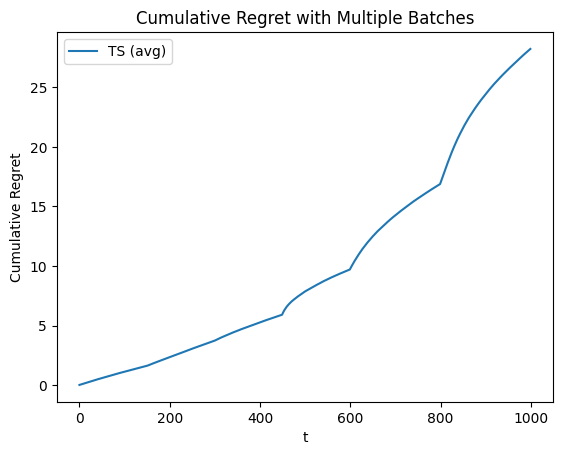

In [13]:
# Cumulative regret (mean over n runs)
plt.figure()
plt.plot(res.mean_cum_regrets, label="TS (avg)")
plt.xlabel("t")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret with Multiple Batches")
plt.legend()
plt.show()

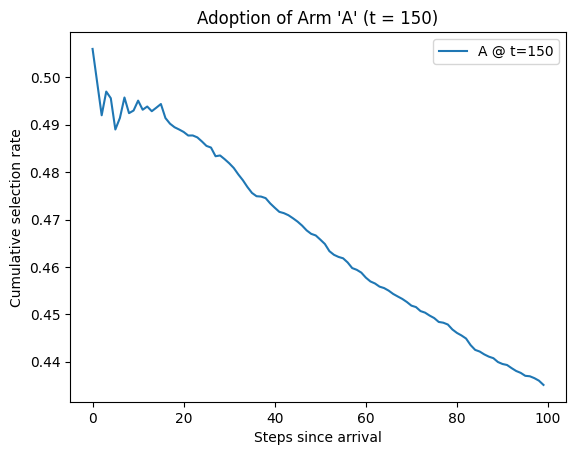

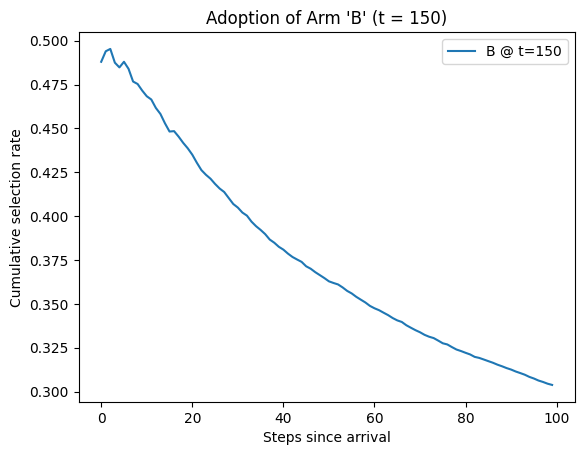

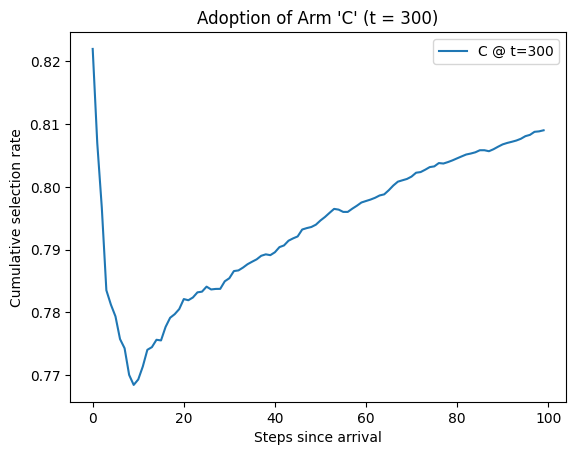

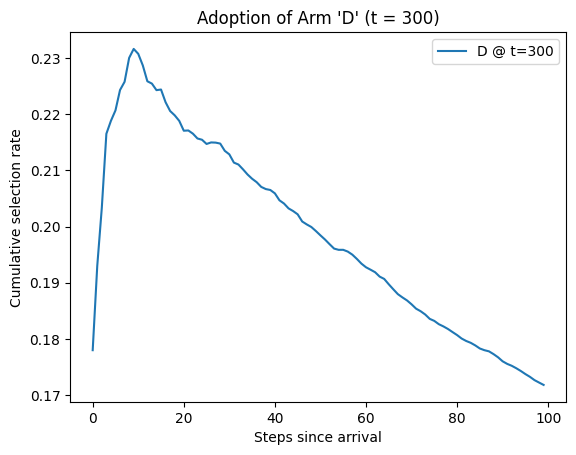

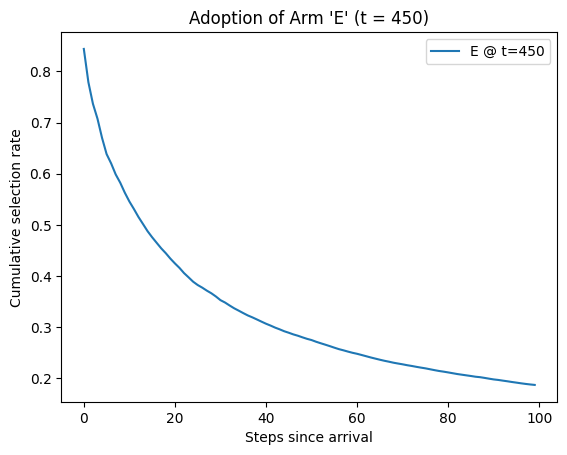

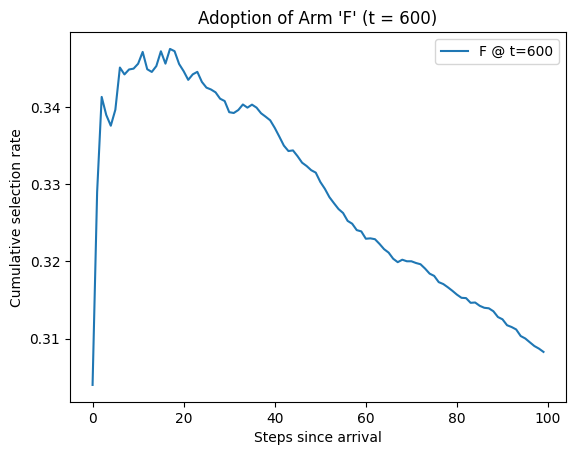

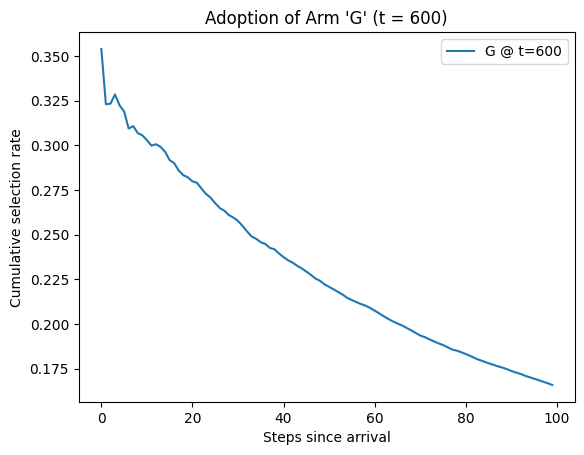

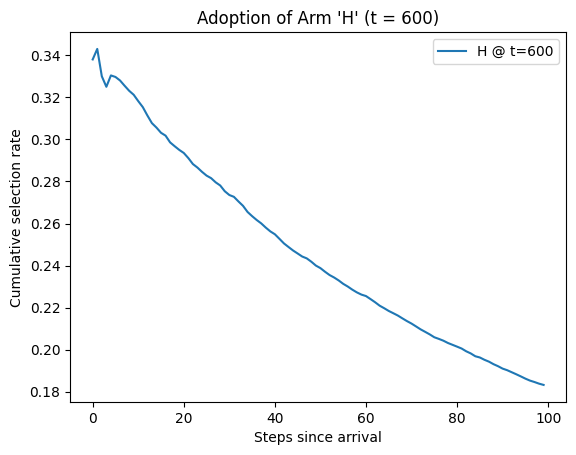

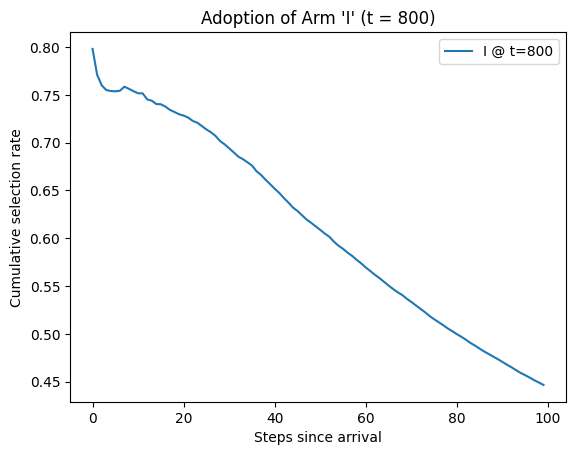

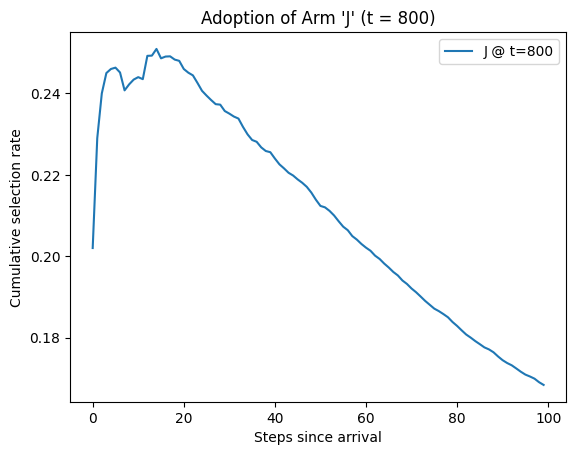

In [14]:
# Adoption plots (mean over n runs)
for arrival_time, arm_index, label in res.new_arm_meta:
    series = res.adoption_averages[(arrival_time, arm_index)]
    plt.figure()
    plt.plot(np.arange(len(series)), series, label=f"{label} @ t={arrival_time}")
    plt.xlabel("Steps since arrival")
    plt.ylabel("Cumulative selection rate")
    plt.title(f"Adoption of Arm '{label}' (t = {arrival_time})")
    plt.legend()
    plt.show()

In [ ]:
rows: List[Dict[str, Union[int, float]]] = []
for arrival_time, arm_index, arm_label in res.new_arm_meta:
    adoption_series: npt.NDArray[np.floating] = res.adoption_averages[
        (arrival_time, arm_index)
    ]
    rows.append(
        {
            "arrival_time": arrival_time,
            "arm_label": arm_label,
            "arm_true_mean_pct": config.batch_new_arms[arrival_time][arm_label] * 100,
            "average_discovery_lag": res.discovery_lags_averages[
                (arrival_time, arm_index)
            ],
            f"expected_pulls_in_first_{res.window_size}_steps": adoption_series[-1]
            * res.window_size,
        }
    )

pl.DataFrame(rows).sort(by=["arrival_time", "arm_label"])

arrival_time,arm_label,arm_true_mean_pct,average_discovery_lag,expected_pulls_in_first_100_steps
i64,str,f64,f64,f64
150,"""A""",4.0,0.732,43.51
150,"""B""",0.9,0.76,30.382
300,"""C""",11.0,0.188,80.902
300,"""D""",3.0,2.498,17.182
450,"""E""",0.3,0.184,18.684
600,"""F""",9.0,1.468,30.828
600,"""G""",0.6,1.46,16.582
600,"""H""",2.0,1.388,18.326
800,"""I""",0.1,0.206,44.668
